# En este cuaderno crearemos un catálogo de las obras disponibles en la plataforma [Teatrix](https://www.teatrix.com/), analizaremos algunos de sus datos y finalmente extraeremos el listado en un archivo de Excel.

En primer lugar, importamos las librerías necesarias para obtener el código de la página y filtrarlo mediante expresiones regulares:

In [1]:
import requests
import re

Hacemos el pedido a la web. Si el valor de su estatus es igual a 200, quiere decir que hemos tenido éxito:

In [2]:
url = 'https://www.teatrix.com/'
request = requests.get(url)
request.status_code

200

A continuación obtenemos los nombres de las páginas que contienen cada una de las obras, ubicados en el texto luego de la expresión "video/".

In [3]:
pattern = 'video/(.+)">'
nombres = re.findall(pattern,request.text)
print(f'La página principal de Teatrix nos devuelve {len(nombres)} nombres de obras')

La página principal de Teatrix nos devuelve 446 nombres de obras


Cada nombre puede aparecer más de una vez en el código, por lo cual necesitamos eliminar los repetidos. Para esto convertimos nuestra lista en un set, estructura que no contiene más de una ocurrencia de cada objeto:

In [4]:
nombres = set(nombres)
print(f'Actualmente, Teatrix cuenta con {len(nombres)} obras en su catálogo.')

Actualmente, Teatrix cuenta con 178 obras en su catálogo.


Ahora creamos un diccionario con la expresión regular correspondiente a cada uno de los datos que queremos extraer:

In [5]:
obras_regex = {'titulo':'title">(.+)</h2','teatro':'origin">(.+)</span>',
               'anio':'date">(\d+)','sinopsis':'md">\s*(.+)',
               'duracion':'duration">(\d+)  min'}
elenco_regex = '"person">(.*?)\s<span\sclass="role">[(](.*?)[)]<'

Entonces ya podemos crear una lista que contenga nombre, teatro, año, duración, elenco y el link al trailer de cada una de las obras. Es posible que la siguiente celda tarde unos cuantos segundos en ejecutarse, ya que debe recorrer página por página y filtrar los datos que queremos en cada una de ellas:

In [6]:
data = [] #Primero creamos la lista que iremos llenando con los datos de cada obra.
for i in nombres: #Iniciamos un bucle que itere el proceso en la página de cada obra.
  url_obra = f'{url}video/{i}' 
  obra_data = {} #Creamos un diccionario vacío cada vez que se inicia un ciclo.
  while len(obra_data) < 1: #Repetimos el ciclo hasta asegurarnos de que obtuvimos
  #datos, ya que puede suceder que a veces el request devuelva un objeto vacío. 
    html = requests.get(url_obra)
    for nombre, regex in obras_regex.items():
      dato = re.findall(regex, html.text)
      if dato: #Si el dato en cuestión es hallado, lo agregamos al diccionario...
        obra_data[nombre] = dato[0] #...tomando el primer elemento para evitar corchetes.
  obra_data['elenco'] = re.findall(elenco_regex, html.text) #Del elenco queremos
  #la lista completa.
  obra_data['trailer'] = f'{url}ver/{i}' #El trailer podemos agregarlo sin necesidad
  #de recurrir a expresiones regulares.
  data.append(obra_data)

Vemos los primeros cinco elementos para comprobar que el proceso haya sido exitoso:

In [ ]:
data[:4]

Antes de seguir importamos la librería Pandas, la cual nos ayudará a manipular los datos:

In [9]:
import pandas as pd

Ahora sí, creamos nuestro catálogo y lo revisamos tomando una muestra al azar:

In [10]:
catalogo = pd.DataFrame(data)
print(catalogo.shape)
catalogo.sample(5)

(178, 7)


,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
165,MUJERES DE CENIZA,Teatro Regina,2016,"Con dirección de R. Antier, esta\r comedia de ...",82,"[(Sergio Marcos, Autoría), (Martín Guerra, Aut...",https://www.teatrix.com/ver/mujeres-de-ceniza
87,PIEZA PLáSTICA,C.C.San Martín,2016,"Una pieza de Marius von Mayenburg, con direcci...",91,"[(Marius von Mayenburg, Autoría), (Luciano Các...",https://www.teatrix.com/ver/pieza-plastica
29,LA MECáNICA DE LAS MARIPOSAS,Teatro Anchieta - San Pablo,2012,Hay una pieza faltante para concretar un sueño...,83,"[(Walter Daguerre, Autoría), (Paulo De Moraes,...",https://www.teatrix.com/ver/a-mecanica-das-bor...
79,YIYA,Teatro El Nacional,2016,"La mítica historia de la asesina de Monserrat,...",107,"[(Bruno Delucchi , Dirección musical ), (Sebas...",https://www.teatrix.com/ver/yiya
153,ARáOZ Y LA VERDAD,Paseo la plaza,2015,La obra de Eduardo Sacheri con dirección de Ga...,87,"[(Fede Adolfi, Musicalizador), (Gabriela Izcov...",https://www.teatrix.com/ver/araoz-y-la-verdad


¿Coincide la cantidad de nombres que extrajimos al principio con la longitud del DataFrame?

In [11]:
#Si esta celda no devuelve nada es porque las cantidades efectivamente coinciden.
assert len(nombres) == len(catalogo), 'Las cantidades no coinciden'

¿Cuáles son las obras más viejas del catálogo?

In [12]:
catalogo[catalogo['anio'] == catalogo['anio'].min()]

,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
9,ALTA COMEDIA: SIN SALIDA,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",70,"[(Luigi Pirandello, Libro original), (Ricardo ...",https://www.teatrix.com/ver/alta-comedia-sin-s...
38,ALTA COMEDIA: PERSONA NO GRATA,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",54,"[(Henrik Ibsen, Libro original), (Ruben Szuchm...",https://www.teatrix.com/ver/alta-comedia-perso...
67,ALTA COMEDIA: SEIS PERSONAJES EN BUSCA DE UN A...,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",64,"[(Luigi Pirandello, Libro original), (Elena An...",https://www.teatrix.com/ver/alta-comedia-seis-...
74,ALTA COMEDIA: HOY DIGO BASTA,Canal 9,1992,"Un episodio de Alta Comedia, el histórico cicl...",74,"[(Juan Carlos Cernadas Lamadrid, Autoría), (Al...",https://www.teatrix.com/ver/alta-comedia-hoy-d...
99,ALTA COMEDIA: LA SANGRE DE LOS ORTIZ,Canal 9,1992,"Un episodio de Alta comedia, el histórico cicl...",61,"[(Patricia Ulanosky, Autoría), (Alberto Rinald...",https://www.teatrix.com/ver/alta-comedia-la-sa...
164,BRUJAS,Teatro Ateneo,1992,"Moria Casán, Graciela Dufau, Nora Cárpena, The...",102,"[(Santiago Moncada, Autoría), (Luis Agustoni, ...",https://www.teatrix.com/ver/brujas


¿De qué años son la mayoría de las obras?

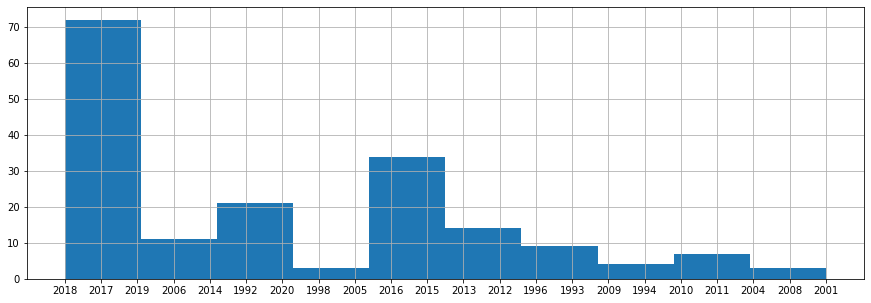

In [13]:
catalogo['anio'].hist(figsize=(15,5));

Ahora crearemos otro DataFrame para analizar la duración de las obras, eliminando los valores nulos, convirtiendo los minutos en datos operables y descartando aquellos que resulten anómalos:

In [14]:
df_dur = catalogo.dropna(subset=['duracion'])
df_dur.shape

(175, 7)

In [15]:
df_dur['duracion'] = df_dur['duracion'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
#Descartamos las obras que duren menos de 20 minutos, cifra arbitraria que tomamos
#como indicadora de datos anómalos:
df_dur = df_dur[df_dur['duracion'] > 20] 

¿Cuál es la obra más corta?

In [17]:
df_dur[df_dur['duracion'] == df_dur['duracion'].min()]

,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
20,ISABEL DE GUEVARA,Centro cultural 25 de mayo,2018,Una obra de la prestigiosa Alicia Muño...,41,"[(Alicia Muñoz, Autoría), (María Esther Fernán...",https://www.teatrix.com/ver/isabel-de-guevara


¿Y la más larga?

In [18]:
df_dur[df_dur['duracion'] == df_dur['duracion'].max()]

,titulo,teatro,anio,sinopsis,duracion,elenco,trailer
106,"ESQUIZOPEñA, INTIMIDAD RIOPLATENSE",Paseo La Plaza,2015,"El inolvidable Fernando Peña, trasgresor y cre...",172,"[(Fernando Peña, Autoría), (Fernando Peña, Act...",https://www.teatrix.com/ver/esquizopena-intimi...


¿Cuál es el promedio de duración de las obras?

In [19]:
prom_dur = df_dur['duracion'].mean()
print(f'El promedio de duración de las obras es de {round(prom_dur)} minutos.')

El promedio de duración de las obras es de 88 minutos.


¿Cómo se distribuyen las obras según su duración?

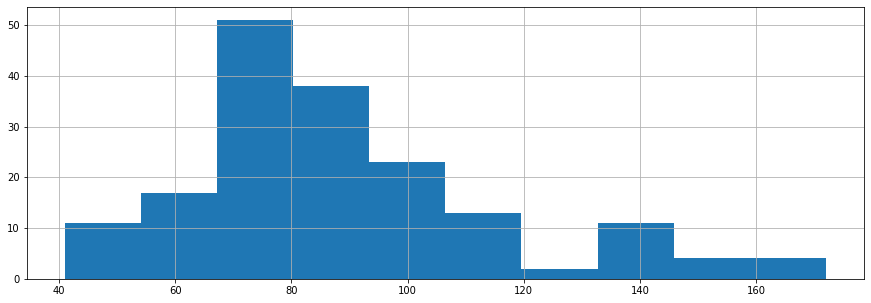

In [20]:
df_dur['duracion'].hist(figsize=(15,5));

Para finalizar, creamos un archivo de Excel con nuestro catálogo:

In [21]:
catalogo.to_excel('catalogo_teatrix.xlsx')